In [ ]:
!pip install snntorch --quiet

# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import surrogate
from snntorch import functional as SF
import torch

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML

# import
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools


In [2]:
import torch.nn.functional as F

### Loading EMNIST

In [3]:
# dataloader arguments
batch_size = 128
data_path='/data/emnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

emnist_train = datasets.EMNIST(data_path, train=True, download=True, transform=transform, split="balanced")
emnist_test = datasets.EMNIST(data_path, train=False, download=True, transform=transform, split="balanced")

# Create DataLoaders
train_loader = DataLoader(emnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 561753746/561753746 [00:29<00:00, 19125619.94it/s]


Extracting /data/emnist/EMNIST/raw/gzip.zip to /data/emnist/EMNIST/raw


### SNN Training Modules

In [4]:
def forge(net, train_loader, test_loader, num_epochs):

    # loss = nn.CrossEntropyLoss()
    loss = SF.mse_count_loss(correct_rate=0.75, incorrect_rate=0.25)
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    loss_hist = []
    acc_hist = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):
        print("===============================================================")
        print("epoch no - ", epoch)
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            # print("target - ", targets)
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, _ = net(data)
            # print('spk_rec_shape', spk_rec.sum(0))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            # loss_val += loss(spk_rec.sum(0), targets)                 # ONLY FOR RATE CODED CROSS ENTROPY
            loss_val += loss(spk_rec, targets)
            # print("loss_val - ", loss_val)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # Print train/test loss/accuracy
            if counter % 100 == 0:
                print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
                # Test set accuracy
                acc = measure_accuracy(net, test_loader)
                acc_hist.append(acc)
            counter += 1


            # if counter == 600:
            #   return loss_hist
            #   break

    return loss_hist, acc_hist

In [5]:
def measure_accuracy(model, dataloader):
    with torch.no_grad():
      model.eval()
      running_length = 0
      running_accuracy = 0

      for data, targets in iter(dataloader):
        data = data.to(device)
        targets = targets.to(device)

        # forward-pass
        spk_rec, _ = model(data)
        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)

        # correct classes for one batch
        num_correct = (max_spike == targets).sum()

        # total accuracy
        running_length += len(targets)
        running_accuracy += num_correct

      accuracy = (running_accuracy / running_length)


      return accuracy.item()

### FF Architecture

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # CRUCIAL PARAMS
        num_hidden = [1000,500]
        self.num_steps = 50
        num_inputs = 28*28
        num_outputs = 47
        beta=0.95
        # spike_grad1 = surrogate.ATan()

        # Initialize 3 layers
        # self.fc1 = nn.Linear(num_inputs, num_hidden[0])
        # self.lif1 = snn.Leaky(beta=beta)
        # self.fc2 = nn.Linear(num_hidden[0], num_hidden[1])
        # self.lif2 = snn.Leaky(beta=beta)
        # self.fc3 = nn.Linear(num_hidden[1], num_outputs)
        # self.lif3 = snn.Leaky(beta=beta)

        # Initialize 2 layers
        self.fc1 = nn.Linear(num_inputs, num_hidden[0])
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden[0], num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        # mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            # print("X shape - ", x.shape)
            cur1 = self.fc1(x.flatten(1))
            # print("cur1 shape - ", cur1.shape)
            spk1, mem1 = self.lif1(cur1, mem1)
            # print("spk1 shape - ", spk1.shape)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # cur3 = self.fc3(spk2)
            # spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk2)
            mem3_rec.append(mem2)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Load the network onto CUDA if available
ff_net = Net().to(device)

In [7]:
loss_hist, acc_hist = forge(ff_net, train_loader, test_loader, num_epochs=1)

epoch no -  0
Iteration: 0 	 Train Loss: 3.0445244312286377
Iteration: 100 	 Train Loss: 0.23151926696300507
Iteration: 200 	 Train Loss: 0.18680517375469208
Iteration: 300 	 Train Loss: 0.17183177173137665
Iteration: 400 	 Train Loss: 0.1541622281074524
Iteration: 500 	 Train Loss: 0.15962432324886322
Iteration: 600 	 Train Loss: 0.14842087030410767
Iteration: 700 	 Train Loss: 0.14703789353370667
Iteration: 800 	 Train Loss: 0.1310039758682251


In [8]:
print(f"Final Test set accuracy: {measure_accuracy(ff_net, test_loader)}")

Final Test set accuracy: 0.7580265402793884


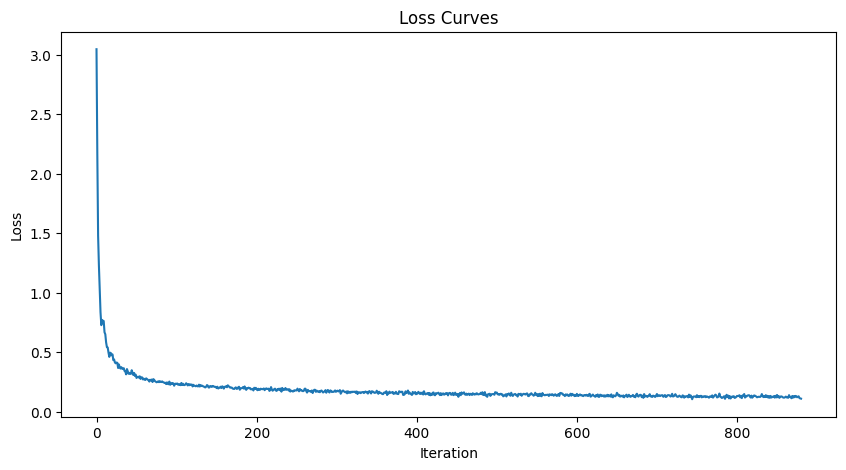

In [9]:
# Plot training loss vs iteration
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
# plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

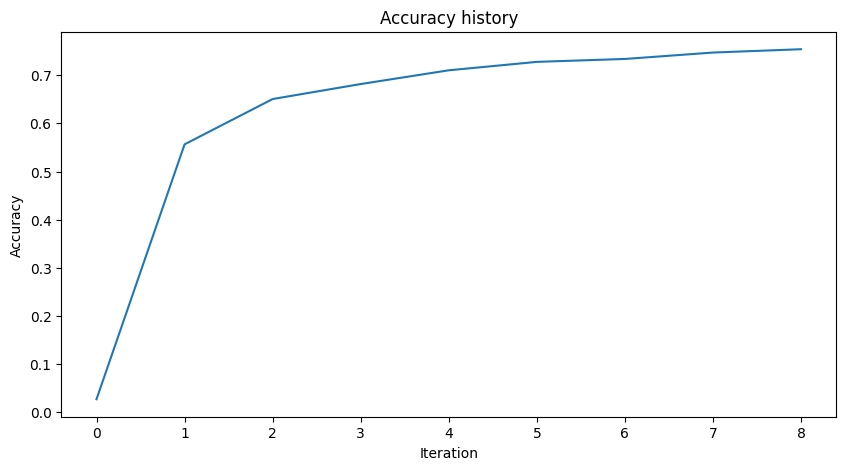

In [10]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(acc_hist)
# plt.plot(test_loss_hist)
plt.title("Accuracy history")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

### CNN

In [11]:
# Define Network
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        spike_grad2 = surrogate.fast_sigmoid(slope=25)
        beta = 0.5
        self.num_steps = 50

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding="same")
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad2)
        self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 12, 5, padding="same")
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad2)
        self.mp2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(7*7*12, 47)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad2)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(self.mp1(cur1), mem1)
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(self.mp2(cur2), mem2)
            cur3 = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)


# Load the network onto CUDA if available
convnet = ConvNet().to(device)

In [12]:
cnn_loss_hist, cnn_acc_hist = forge(convnet, train_loader, test_loader, 1)

epoch no -  0
Iteration: 0 	 Train Loss: 3.4012765884399414
Iteration: 100 	 Train Loss: 0.7932878732681274
Iteration: 200 	 Train Loss: 0.37640291452407837
Iteration: 300 	 Train Loss: 0.34307509660720825
Iteration: 400 	 Train Loss: 0.3037267029285431
Iteration: 500 	 Train Loss: 0.32771605253219604
Iteration: 600 	 Train Loss: 0.2511768341064453
Iteration: 700 	 Train Loss: 0.24887299537658691
Iteration: 800 	 Train Loss: 0.2491622269153595


In [13]:
print(f"Final Convnet Test set accuracy: {measure_accuracy(convnet, test_loader)}")

Final Convnet Test set accuracy: 0.6556078791618347


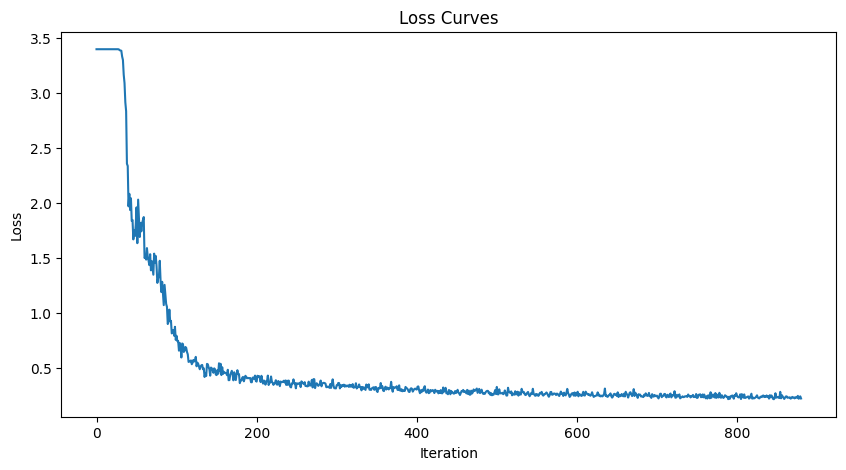

In [14]:
# Plot training loss vs iteration
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(cnn_loss_hist)
# plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

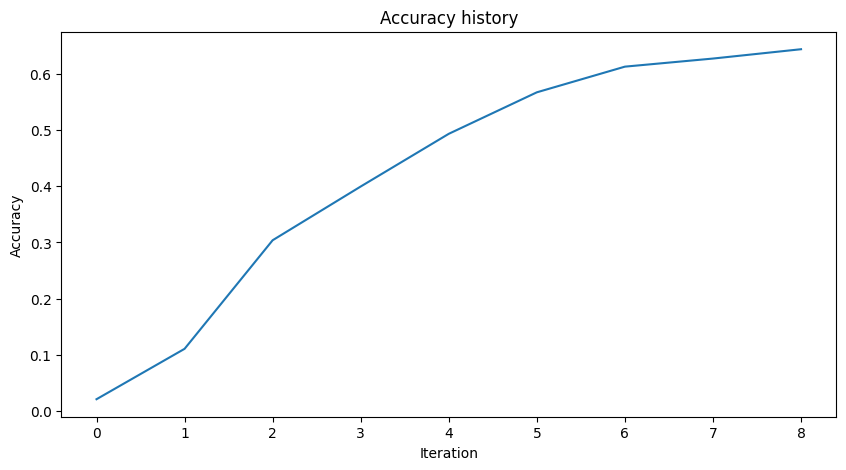

In [15]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(cnn_acc_hist)
# plt.plot(test_loss_hist)
plt.title("Accuracy history")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()